
# 📚 Book Recommendation Project — Data Cleaning & EDA

This notebook continues from our two scraping notebooks:

- `scrape_goodreads_best_books_ever.ipynb`
- `scrape_openLibrary_trending_api.ipynb`

We now:

1. Load & concatenate both datasets.
2. Clean & preprocess:
   - Remove duplicates & missing values
   - Normalize text (titles, genres, authors)
   - Convert genres to lists
   - Standardize ratings (0–5)
   - Extract simple keywords using TF-IDF
3. Exploratory Data Analysis (EDA):
   - Top rated books
   - Popular authors
   - Genre distribution
   - Rating patterns & correlations
   - Word cloud of frequent terms

In [32]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os

from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# Optional wordcloud
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except:
    WORDCLOUD_AVAILABLE = False

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)


## 1. Load the two datasets


In [33]:
# Load Goodreads data
goodreads_path = "..\data\goodreads_best_books_600.csv"

if not os.path.exists(goodreads_path):
    goodreads_path = "goodreads_best_books_600.csv"
    
df_gr = pd.read_csv(goodreads_path)
print("Goodreads shape:", df_gr.shape)
df_gr.head(3)

Goodreads shape: (600, 11)


,rank,title,author,author_url,avg_rating,num_ratings,genres,year,score,votes,book_url
0,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,https://www.goodreads.com/author/show/153394.S...,4.35,9748182,"['Young Adult', 'Dystopia', 'Fiction', 'Fantas...",2008.0,4283248,43546,https://www.goodreads.com/book/show/2767052-th...
1,2,Pride and Prejudice,Jane Austen,https://www.goodreads.com/author/show/1265.Jan...,4.29,4722539,"['Classics', 'Romance', 'Fiction', 'Historical...",1813.0,2945744,30189,https://www.goodreads.com/book/show/1885.Pride...
2,3,To Kill a Mockingbird,Harper Lee,https://www.goodreads.com/author/show/1825.Har...,4.26,6784603,"['Classics', 'Fiction', 'Historical Fiction', ...",1960.0,2589212,26439,https://www.goodreads.com/book/show/2657.To_Ki...


In [34]:
# Load Open Library data
openlib_path = "..\data\openlibrary_trending_600.csv"

if not os.path.exists(openlib_path):
    openlib_path = "openlibrary_trending_600.csv"

df_ol = pd.read_csv(openlib_path)
print("Open Library shape:", df_ol.shape)
df_ol.head(3)

Open Library shape: (600, 10)


,rank_in_page,title,author,author_url,avg_rating,num_ratings,year,score,book_url,genres
0,1,Kitchen Confidential,Anthony Bourdain,https://openlibrary.org/authors/OL543322A,4.04,49.0,2000.0,132,https://openlibrary.org/works/OL3348011W,"Cooks, Cocineros, History, New York Times best..."
1,2,Siddhartha,Hermann Hesse,https://openlibrary.org/authors/OL76437A,4.09,55.0,1922.0,254,https://openlibrary.org/works/OL872932W,"Alegorías, Buddha (The concept), Buddha and Bu..."
2,3,Silence,Shūsaku Endō,https://openlibrary.org/authors/OL4282449A,4.17,6.0,1980.0,91,https://openlibrary.org/works/OL15391655W,"Fiction, Christians, History, Missionaries in ..."



## 2. Add `source` column and align columns


In [35]:
df_gr["source"] = "goodreads"
df_ol["source"] = "openlibrary"

needed_cols = [
    "title",
    "author",
    "author_url",
    "avg_rating",
    "num_ratings",
    "year",
    "genres",
    "score",
    "votes",
    "book_url"
]

for col in needed_cols:
    if col not in df_gr.columns:
        df_gr[col] = np.nan
    if col not in df_ol.columns:
        df_ol[col] = np.nan


## 3. Concatenate


In [36]:
df = pd.concat([df_gr, df_ol], ignore_index=True)
print("Combined shape:", df.shape)
df.head(5)

Combined shape: (1200, 13)


,rank,title,author,author_url,avg_rating,num_ratings,genres,year,score,votes,book_url,source,rank_in_page
0,1.0,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,https://www.goodreads.com/author/show/153394.S...,4.35,9748182.0,"['Young Adult', 'Dystopia', 'Fiction', 'Fantas...",2008.0,4283248,43546.0,https://www.goodreads.com/book/show/2767052-th...,goodreads,NaN
1,2.0,Pride and Prejudice,Jane Austen,https://www.goodreads.com/author/show/1265.Jan...,4.29,4722539.0,"['Classics', 'Romance', 'Fiction', 'Historical...",1813.0,2945744,30189.0,https://www.goodreads.com/book/show/1885.Pride...,goodreads,NaN
2,3.0,To Kill a Mockingbird,Harper Lee,https://www.goodreads.com/author/show/1825.Har...,4.26,6784603.0,"['Classics', 'Fiction', 'Historical Fiction', ...",1960.0,2589212,26439.0,https://www.goodreads.com/book/show/2657.To_Ki...,goodreads,NaN
3,4.0,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,https://www.goodreads.com/author/show/1077326....,4.50,3745274.0,"['Fantasy', 'Young Adult', 'Fiction', 'Harry P...",2003.0,2070361,21065.0,https://www.goodreads.com/book/show/58613451-h...,goodreads,NaN
4,5.0,The Book Thief,Markus Zusak,https://www.goodreads.com/author/show/11466.Ma...,4.39,2840351.0,"['Historical Fiction', 'Fiction', 'Young Adult...",2005.0,1958034,20112.0,https://www.goodreads.com/book/show/19063.The_...,goodreads,NaN


In [37]:
df.isnull().sum()

rank            600
title             0
author            2
author_url        2
avg_rating      104
num_ratings     104
genres           35
year             24
score             0
votes           600
book_url          0
source            0
rank_in_page    600
dtype: int64


## 4. Basic Cleaning: duplicates & missing


In [38]:
# Store original DataFrame before cleaning
df_original = df.copy()

# Drop irrelevant columns
df_after_dropna = df.drop(columns = ["rank", "rank_in_page", 'votes']).copy()   # Added .copy()

# Basic strip to remove leading/trailing spaces
df_after_dropna["title_clean"] = df_after_dropna["title"].astype(str).str.strip()
df_after_dropna["author_clean"] = df_after_dropna["author"].astype(str).str.strip()

# Collapse multiple spaces inside strings
#    "stephen        king" -> "stephen king"
df_after_dropna["title_clean"] = df_after_dropna["title_clean"].str.replace(r"\s+", " ", regex=True)
df_after_dropna["author_clean"] = df_after_dropna["author_clean"].str.replace(r"\s+", " ", regex=True)

# Remove unwanted characters:
#    Keep ONLY:
#      - letters A–Z / a–z
#      - digits 0–9
#      - spaces
#      - parentheses ( )
#    Everything else (â, Ã, Å, /, &, -, =, quotes, etc.) becomes a space.
allowed_pattern = r"[^A-Za-z0-9\s\(\)]"

df_after_dropna["title_clean"] = df_after_dropna["title_clean"].str.replace(allowed_pattern, " ", regex=True)
df_after_dropna["author_clean"] = df_after_dropna["author_clean"].str.replace(allowed_pattern, " ", regex=True)

# Collapse spaces again after replacements and strip
df_after_dropna["title_clean"] = df_after_dropna["title_clean"].str.replace(r"\s+", " ", regex=True).str.strip()
df_after_dropna["author_clean"] = df_after_dropna["author_clean"].str.replace(r"\s+", " ", regex=True).str.strip()

# Lowercase helper columns for matching / duplicates
df_after_dropna["title_clean"] = df_after_dropna["title_clean"].str.lower()
df_after_dropna["author_clean"] = df_after_dropna["author_clean"].str.lower()

# Identify rows with missing or empty title/author (using the cleaned columns)
rows_missing_title_author = df_after_dropna[
    (df_after_dropna["title_clean"].isna()) |
    (df_after_dropna["title_clean"].str.strip() == "") |
    (df_after_dropna["author_clean"].isna()) |
    (df_after_dropna["author_clean"].str.strip() == "")
].copy()

print("Rows with missing/empty title or author (sample):")
display(rows_missing_title_author[["title", "author", "title_clean", "author_clean"]].head(10))
print("Total rows to remove (missing/empty title/author):", len(rows_missing_title_author))

# Keep only rows where both title_clean and author_clean are non-null and non-empty
df_after_dropna = df_after_dropna[
    (~df_after_dropna["title_clean"].isna()) &
    (df_after_dropna["title_clean"].str.strip() != "") &
    (~df_after_dropna["author_clean"].isna()) &
    (df_after_dropna["author_clean"].str.strip() != "")
]

print("Shape after removing rows with missing/empty title/author:", df_after_dropna.shape)

# Find duplicated books
duplicate_mask = df_after_dropna.duplicated(subset=["title_clean", "author_clean"], keep='first')
duplicate_rows = df_after_dropna[duplicate_mask].copy()  # Added .copy()

# Final cleaned DataFrame
df_final = df_after_dropna.drop_duplicates(subset=["title_clean", "author_clean"])

# Create DataFrame with all dropped rows
dropped_rows = pd.concat([
    rows_missing_title_author.assign(drop_reason='missing_title_or_author'),
    duplicate_rows.assign(drop_reason='duplicate')
], ignore_index=True)

print(f"Original shape: {df_original.shape}")
print(f"Rows dropped due to duplicates: {len(duplicate_rows)}")
print(f"Total dropped rows: {len(dropped_rows)}")

# Display dropped rows
print("\nDropped rows DataFrame:")
display(dropped_rows[['title', 'author', 'source', 'drop_reason']].head(15))

# Drop all rows with any missing values
df_no_missing = df_final.dropna()

print(f"Rows with missing values: {df_final.shape[0] - df_no_missing.shape[0]}")
print(f"After dropping all rows with missing values: {df_no_missing.shape}")
print(f"Rows dropped: {df_original.shape[0] - df_no_missing.shape[0]}")
print(f"Final cleaned shape: {df_no_missing.shape}")

# Update df to the version without missing values
df = df_no_missing

Rows with missing/empty title or author (sample):


,title,author,title_clean,author_clean
436,القرآن الكريم,Anonymous,,anonymous
465,زندگی مه آلود پریا,سید مرتضی مصطفوی,,
596,انتحار فاشل,أحمد جمال الدين رمضان,,
712,Государство и революция,Vladimir Il’ich Lenin,,vladimir il ich lenin
850,ONE PIECE 1,尾田栄一郎,one piece 1,
981,Taiyō to tetsu,三島由紀夫,taiy to tetsu,
1068,海辺のカフカ,村上春樹,,
1116,소년이 온다,Han Kang,,han kang
1125,Κρίτων / Φαίδων / Ἀπολογία Σωκράτους,Πλάτων,,
1140,三体,刘慈欣,,


Total rows to remove (missing/empty title/author): 10
Shape after removing rows with missing/empty title/author: (1190, 12)
Original shape: (1200, 13)
Rows dropped due to duplicates: 30
Total dropped rows: 40

Dropped rows DataFrame:


,title,author,source,drop_reason
0,القرآن الكريم,Anonymous,goodreads,missing_title_or_author
1,زندگی مه آلود پریا,سید مرتضی مصطفوی,goodreads,missing_title_or_author
2,انتحار فاشل,أحمد جمال الدين رمضان,goodreads,missing_title_or_author
3,Государство и революция,Vladimir Il’ich Lenin,openlibrary,missing_title_or_author
4,ONE PIECE 1,尾田栄一郎,openlibrary,missing_title_or_author
5,Taiyō to tetsu,三島由紀夫,openlibrary,missing_title_or_author
6,海辺のカフカ,村上春樹,openlibrary,missing_title_or_author
7,소년이 온다,Han Kang,openlibrary,missing_title_or_author
8,Κρίτων / Φαίδων / Ἀπολογία Σωκράτους,Πλάτων,openlibrary,missing_title_or_author
9,三体,刘慈欣,openlibrary,missing_title_or_author


Rows with missing values: 150
After dropping all rows with missing values: (1010, 12)
Rows dropped: 190
Final cleaned shape: (1010, 12)


In [39]:
df.shape

(1010, 12)

In [40]:
# Sanity Checks
df.isnull().sum()

title           0
author          0
author_url      0
avg_rating      0
num_ratings     0
genres          0
year            0
score           0
book_url        0
source          0
title_clean     0
author_clean    0
dtype: int64


## 5. Normalize genres


In [41]:
# Work on a copy (good practice)
df = df.copy()

# Ensure 'genres' column exists
if "genres" not in df.columns:
    df["genres"] = ""

# Normalize to string and basic strip
df["genres"] = df["genres"].fillna("").astype(str).str.strip().str.lower()

genres_list = []

for g in df["genres"]:
    # Unify common separators into space so we can split later
    # (anything like "/", "&", "=" will behave like a separator)
    g = g.replace("/", ",")
    g = g.replace("&", ",")
    g = g.replace("=", ",")
    g = g.replace(";", ",")
    g = g.replace("|", ",")
    g = g.replace("--", ",")
    g = g.replace("-", ",")
    g = g.replace(":", ",")
    #g = g.replace(",", " ")

    # Remove brackets, quotes, parentheses (we don't want them as text)
    g = g.replace("[", " ").replace("]", " ")
    g = g.replace("(", " ").replace(")", " ")
    g = g.replace("'", " ").replace('"', " ")

    # Keep ONLY letters + commas + spaces (no numbers, no symbols)
    g = re.sub(r"[^a-z,\s]", " ", g)

    # Collapse multiple spaces
    g = re.sub(r"\s+", " ", g).strip()

    if g == "":
        genres_list.append([])
    else:
        # Split by comma into candidate genre labels
        raw_parts = [p.strip() for p in g.split(",")]

        final_parts = []
        for p in raw_parts:
            # Collapse spaces again (just in case) and strip
            p = re.sub(r"\s+", " ", p).strip()

            # 4) Filter out empty / very short / junk-like tokens
            #    - length <= 3 is usually noise ("ya", "sf", "and", etc.)
            #    - drop some common junk prefixes (nyt, pz, etc.)
            if p != "" and len(p) > 3:
                if not p.startswith(("nyt", "pz", "loc", "ol")):
                    # 5) Avoid duplicates within this book's genres
                    if p not in final_parts:
                        final_parts.append(p)

        genres_list.append(final_parts)

# Save cleaned genres
df["genres_list"] = genres_list
df["genres_clean"] = df["genres_list"].apply(lambda x: ", ".join(x))

# Quick check
df[["title", "genres", "genres_list", "genres_clean"]].head(15)

,title,genres,genres_list,genres_clean
0,"The Hunger Games (The Hunger Games, #1)","['young adult', 'dystopia', 'fiction', 'fantas...","[young adult, dystopia, fiction, fantasy, scie...","young adult, dystopia, fiction, fantasy, scien..."
1,Pride and Prejudice,"['classics', 'romance', 'fiction', 'historical...","[classics, romance, fiction, historical fictio...","classics, romance, fiction, historical fiction..."
2,To Kill a Mockingbird,"['classics', 'fiction', 'historical fiction', ...","[classics, fiction, historical fiction, school...","classics, fiction, historical fiction, school,..."
3,Harry Potter and the Order of the Phoenix (Har...,"['fantasy', 'young adult', 'fiction', 'harry p...","[fantasy, young adult, fiction, harry potter, ...","fantasy, young adult, fiction, harry potter, m..."
4,The Book Thief,"['historical fiction', 'fiction', 'young adult...","[historical fiction, fiction, young adult, cla...","historical fiction, fiction, young adult, clas..."
5,"Twilight (The Twilight Saga, #1)","['fantasy', 'young adult', 'romance', 'fiction...","[fantasy, young adult, romance, fiction, vampi...","fantasy, young adult, romance, fiction, vampir..."
6,Animal Farm,"['classics', 'fiction', 'dystopia', 'fantasy',...","[classics, fiction, dystopia, fantasy, school,...","classics, fiction, dystopia, fantasy, school, ..."
7,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,"['fantasy', 'fiction', 'classics', 'adventure'...","[fantasy, fiction, classics, adventure, scienc...","fantasy, fiction, classics, adventure, science..."
8,The Chronicles of Narnia (The Chronicles of Na...,"['fantasy', 'classics', 'fiction', 'young adul...","[fantasy, classics, fiction, young adult, chil...","fantasy, classics, fiction, young adult, child..."
9,The Fault in Our Stars,"['young adult', 'romance', 'fiction', 'contemp...","[young adult, romance, fiction, contemporary, ...","young adult, romance, fiction, contemporary, r..."



## 6. Standardize ratings (0–5)


In [42]:
# Make sure we're working with a proper DataFrame copy
df = df.copy()

df["avg_rating"] = pd.to_numeric(df["avg_rating"], errors="coerce")

df["rating_0_5"] = df["avg_rating"]

mask_10 = (df["rating_0_5"] > 5) & (df["rating_0_5"] <= 10)
df.loc[mask_10, "rating_0_5"] = df.loc[mask_10, "rating_0_5"] / 2.0

df["rating_0_5"] = df["rating_0_5"].clip(lower=0, upper=5)

df[["avg_rating", "rating_0_5"]].head(10)

,avg_rating,rating_0_5
0,4.35,4.35
1,4.29,4.29
2,4.26,4.26
3,4.50,4.50
4,4.39,4.39
5,3.67,3.67
6,4.01,4.01
7,4.61,4.61
8,4.28,4.28
9,4.12,4.12



## 7. Clean `num_ratings`


In [43]:
# Make sure we're working with a proper DataFrame copy
df = df.copy()

df["num_ratings"] = pd.to_numeric(df["num_ratings"], errors="coerce").fillna(0)
df["num_ratings"] = df["num_ratings"].astype(int)
df[["title", "num_ratings"]].head(5)

,title,num_ratings
0,"The Hunger Games (The Hunger Games, #1)",9748182
1,Pride and Prejudice,4722539
2,To Kill a Mockingbird,6784603
3,Harry Potter and the Order of the Phoenix (Har...,3745274
4,The Book Thief,2840351



## 8. Text for TF-IDF Keywords


In [44]:
# Make sure we're working with a proper DataFrame copy
df = df.copy()

df["text_for_keywords"] = df["title_clean"].fillna("").astype(str) + " " + df["genres_list"].fillna("").astype(str)
df["text_for_keywords"] = df["text_for_keywords"].str.lower()
df["text_for_keywords"].sample(10)

311     the complete calvin and hobbes ['comics', 'hum...
385     the graveyard book ['fantasy', 'young adult', ...
982     women who run with the wolves ['archetype psyc...
1005    we wish to inform you that tomorrow we will be...
113     dark places ['mystery', 'thriller', 'fiction',...
916     the rainbow ['fiction', 'families', 'family', ...
720     the coldest winter ever ['inner cities', 'afri...
538     the return of the king (the lord of the rings ...
296     uglies (uglies 1) ['young adult', 'dystopia', ...
838     all american boys ['race relations', 'crime', ...
Name: text_for_keywords, dtype: object


## 9. TF-IDF Keyword Extraction


In [45]:
max_features = 50

vectorizer = TfidfVectorizer(
    max_features=max_features,
    stop_words="english"
)

tfidf_matrix = vectorizer.fit_transform(df["text_for_keywords"])
feature_names = vectorizer.get_feature_names_out()

print("TF-IDF shape:", tfidf_matrix.shape)
print("Some features:", feature_names[:100])

TF-IDF shape: (1010, 50)
Some features: ['adult' 'adventure' 'american' 'audiobook' 'bestseller' 'book' 'books'
 'character' 'children' 'childrens' 'classics' 'club' 'contemporary'
 'detective' 'english' 'fantasy' 'fiction' 'fictitious' 'general' 'grade'
 'historical' 'history' 'horror' 'juvenile' 'language' 'large' 'life'
 'literary' 'literature' 'middle' 'mystery' 'new' 'nonfiction' 'novels'
 'paranormal' 'philosophy' 'psychology' 'romance' 'school' 'science'
 'social' 'stories' 'suspense' 'thriller' 'times' 'type' 'women' 'works'
 'york' 'young']


In [46]:
top_keywords_list = []

for i in range(tfidf_matrix.shape[0]):
    row = tfidf_matrix[i].toarray()[0]
    top_idx = row.argsort()[::-1]
    book_keywords = []
    for idx in top_idx:
        if row[idx] > 0:
            word = feature_names[idx]
            if word not in book_keywords:
                book_keywords.append(word)
        if len(book_keywords) >= 5:
            break
    top_keywords_list.append(", ".join(book_keywords))

df["top_keywords"] = top_keywords_list
df[["title", "top_keywords", "genres_list", "source"]].tail(15)

,title,top_keywords,genres_list,source
1179,The Clan of the Cave Bear,"character, fiction, historical, language, fict...","[neanderthals, shamanism, sign language, taboo...",openlibrary
1181,The Practice of Management,"nonfiction, science","[business, nonfiction, industrial management, ...",openlibrary
1182,Nutricide,,"[nutrition, blacks, nutritionally induced dise...",openlibrary
1184,La favorita,,"[operas, librettos, ballets, scenarios, vocal ...",openlibrary
1185,The Feminine Mystique,"women, social, psychology","[femmes, conditions sociales, discrimination l...",openlibrary
1186,Technical Analysis of the Financial Markets,,"[futures market, commodity exchanges, investme...",openlibrary
1187,The Negroes and the Jews,,"[african americans, relations with jews, negro...",openlibrary
1188,"""Get us out of here!!""",,"[spiritualism, purgatory, interviews]",openlibrary
1190,The Crystal Shard,"american, fantasy, character, fictitious, fiction","[fiction, dungeons, dragons novel, epic, elves...",openlibrary
1191,La Chute,"fiction, literature, language, philosophy, lit...","[conscience, continental european fiction fict...",openlibrary



## 10. Save cleaned dataset


In [47]:
# Save to CSV
output_path = "../data/books_merged_cleaned.csv"
df.to_csv(output_path, index=False, encoding="utf-8")
print("Saved:", output_path, "shape:", df.shape)

Saved: ../data/books_merged_cleaned.csv shape: (1010, 17)


In [48]:
df.columns

Index(['title', 'author', 'author_url', 'avg_rating', 'num_ratings', 'genres',
       'year', 'score', 'book_url', 'source', 'title_clean', 'author_clean',
       'genres_list', 'genres_clean', 'rating_0_5', 'text_for_keywords',
       'top_keywords'],
      dtype='object')


# 11. EDA
### 11.1 Rating distribution


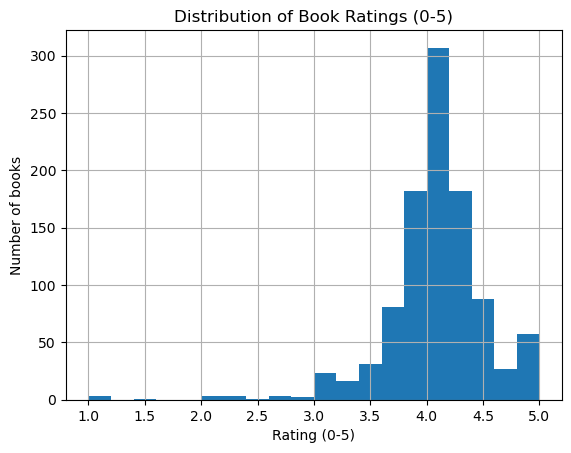

In [49]:
plt.figure()
df["rating_0_5"].hist(bins=20)
plt.xlabel("Rating (0-5)")
plt.ylabel("Number of books")
plt.title("Distribution of Book Ratings (0-5)")
plt.savefig("../figures/eda_rating_distribution.png", dpi=300)
plt.show()


### 11.2 Top authors


author_clean
stephen king       16
agatha christie    12
margaret way       11
rick riordan       10
j k rowling        10
cassandra clare     8
j r r tolkien       8
sarah j maas        8
charles dickens     7
jane austen         7
Name: count, dtype: int64


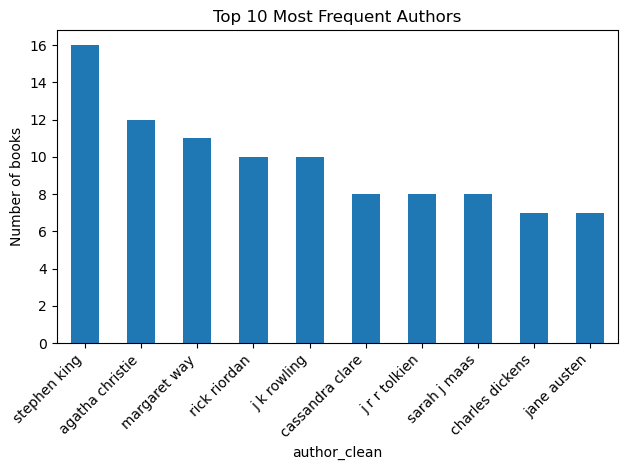

In [50]:
top_authors = df["author_clean"].value_counts().head(10)
print(top_authors)

plt.figure()
top_authors.plot(kind="bar")
plt.ylabel("Number of books")
plt.title("Top 10 Most Frequent Authors")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("../figures/eda_top_authors.png", dpi=300)
plt.show()


### 11.3 Genre distribution


In [51]:
genre_counter = Counter()
for gen_list in df["genres_list"]:
    for g in gen_list:
        genre_counter[g] += 1

genre_counts = pd.Series(genre_counter).sort_values(ascending=False)
genre_counts.head(15)

fiction               768
classics              313
fantasy               270
romance               214
young adult           200
historical fiction    164
general               154
literature            148
audiobook             130
mystery               125
historical            115
contemporary          114
book club             113
science fiction        99
adventure              95
dtype: int64

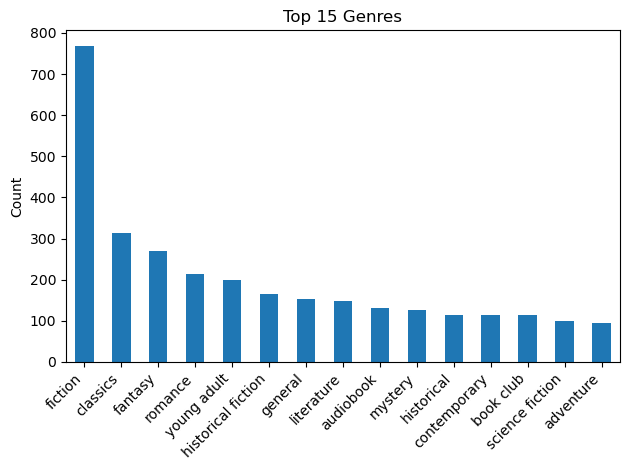

In [52]:
plt.figure()
genre_counts.head(15).plot(kind="bar")
plt.ylabel("Count")
plt.title("Top 15 Genres")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("../figures/eda_top_genres.png", dpi=300)
plt.show()


### 11.4 Rating vs Number of Ratings


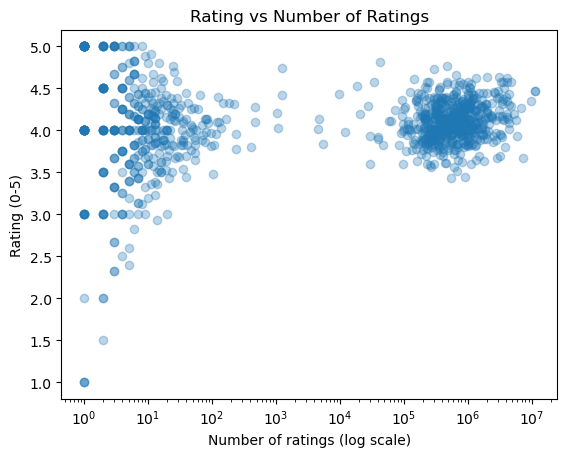

In [53]:
plt.figure()
plt.scatter(df["num_ratings"], df["rating_0_5"], alpha=0.3)
plt.xscale("log")
plt.xlabel("Number of ratings (log scale)")
plt.ylabel("Rating (0-5)")
plt.title("Rating vs Number of Ratings")
plt.savefig("../figures/eda_rating_vs_num_ratings.png", dpi=300)
plt.show()


### 11.5 Simple correlations


In [54]:
corr_cols = ["rating_0_5", "num_ratings", "score"]
existing = [c for c in corr_cols if c in df.columns]
df[existing].corr()

,rating_0_5,num_ratings,score
rating_0_5,1.000000,0.100458,0.073876
num_ratings,0.100458,1.000000,0.641170
score,0.073876,0.641170,1.000000



### 11.6 Word Cloud


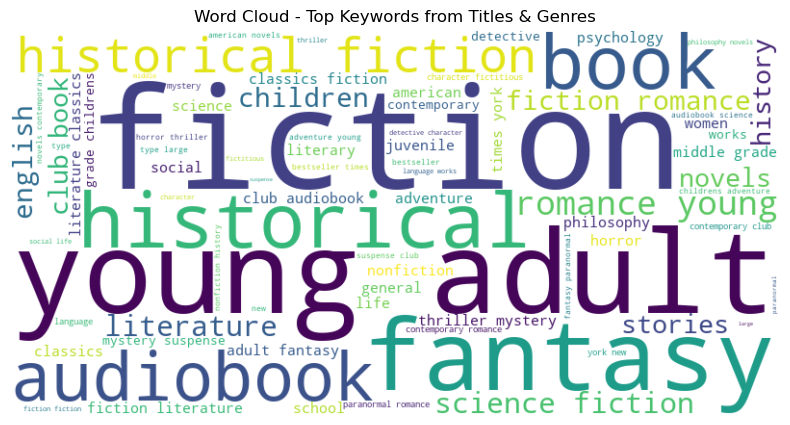

In [55]:
text_all = " ".join(df["top_keywords"].tolist())
wc = WordCloud(width=800, height=400, background_color="white").generate(text_all)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Top Keywords from Titles & Genres")
plt.savefig("../figures/eda_wordcloud_titles_genres.png", dpi=300, bbox_inches="tight")
plt.show()